#### Inicialização de variáveis e importação de bibliotecas

In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input


AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 250
img_width = 250
data_dir='data/cuted/'
predict_dir='predict/'

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  predict_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4735 files belonging to 3 classes.
Using 3788 files for training.
Found 0 files belonging to 0 classes.
Using 0 files for validation.


ValueError: No images found in directory predict/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [19]:
class_names = train_ds.class_names
print(class_names)

['header', 'non-header']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-16 10:52:33.726490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33869056 bytes after encountering the first element of size 33869056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-04-16 10:52:34.169660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


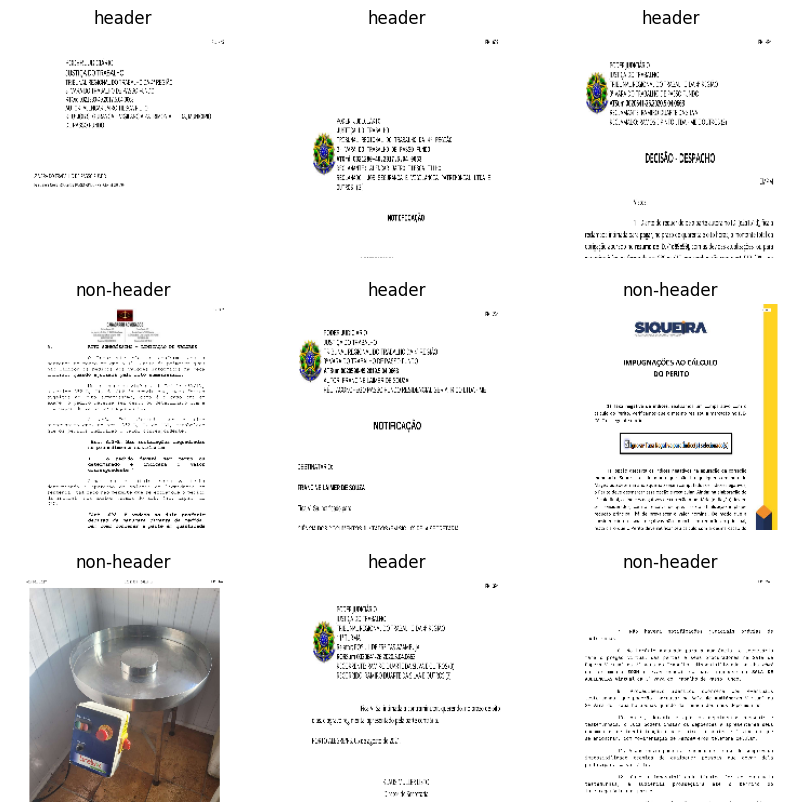

In [20]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [22]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/daviga/projects/machine-learning/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-04-16 10:52:43.110780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33869056 bytes after encountering the first element of size 33869056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-04-16 10:52:43.110975: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33869056 bytes after encountering the first element of size 33869056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-04-16 10:52:43.938502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


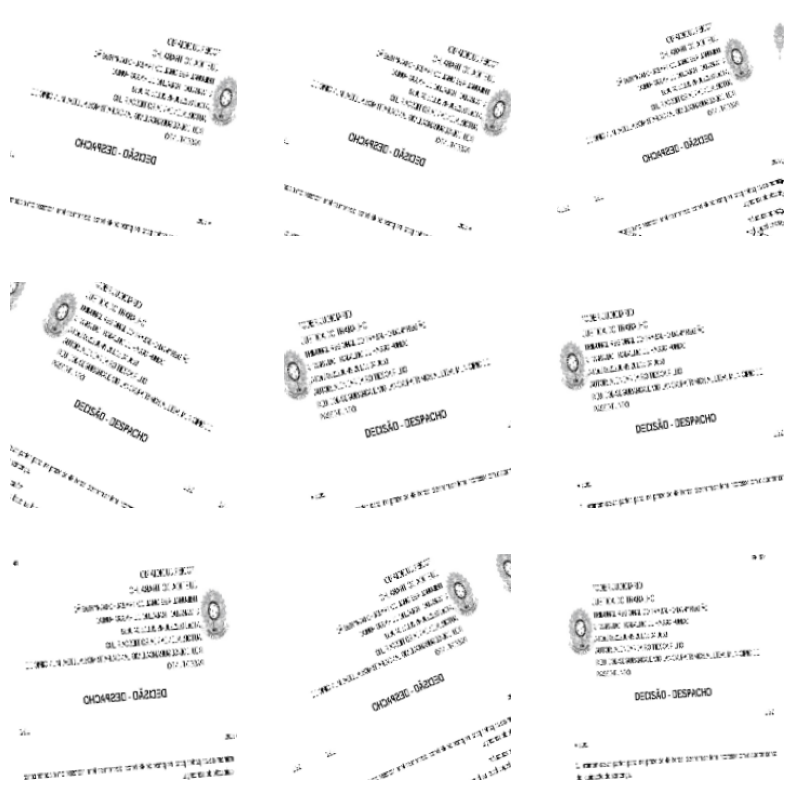

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
num_classes = len(class_names)

model = Sequential([
  layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 210, 210, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 210, 210, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 210, 210, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 210, 210, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 210, 210, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 105, 105, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 105, 105, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,561,762 (21.22 MB)

 Trainable params: 5,561,762 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4986 - loss: 1.4508

2024-04-16 10:52:54.970584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33869056 bytes after encountering the first element of size 33869056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.4995 - loss: 1.4308 - val_accuracy: 0.7038 - val_loss: 0.6491
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.6405 - loss: 0.6353 - val_accuracy: 0.7478 - val_loss: 0.5177
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.7905 - loss: 0.4292 - val_accuracy: 0.8123 - val_loss: 0.6152
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.7974 - loss: 0.4518 - val_accuracy: 0.7478 - val_loss: 0.8682
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.8583 - loss: 0.3469 - val_accuracy: 0.7859 - val_loss: 0.7085
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.8939 - loss: 0.2686 - val_accuracy: 0.8768 - val_loss: 0.4241
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.9191 - loss: 0.2021 - val_accuracy: 0.8446 - val_loss: 0.5337
Epoch 8/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - accuracy: 0.9219 - loss: 0.2209 - val_accuracy: 0.9032 - v

In [28]:
model.save('model.keras')

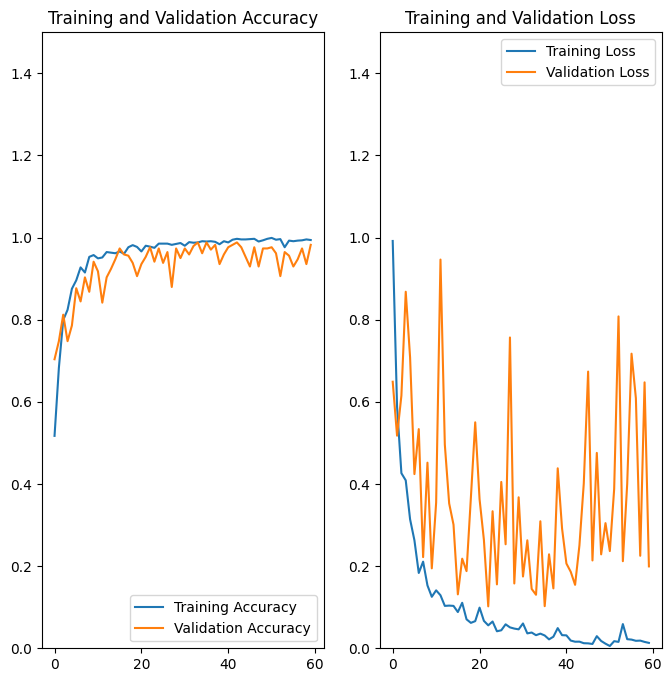

In [29]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.5]) 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim([0, 1.5])
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


2024-04-16 11:01:09.958687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


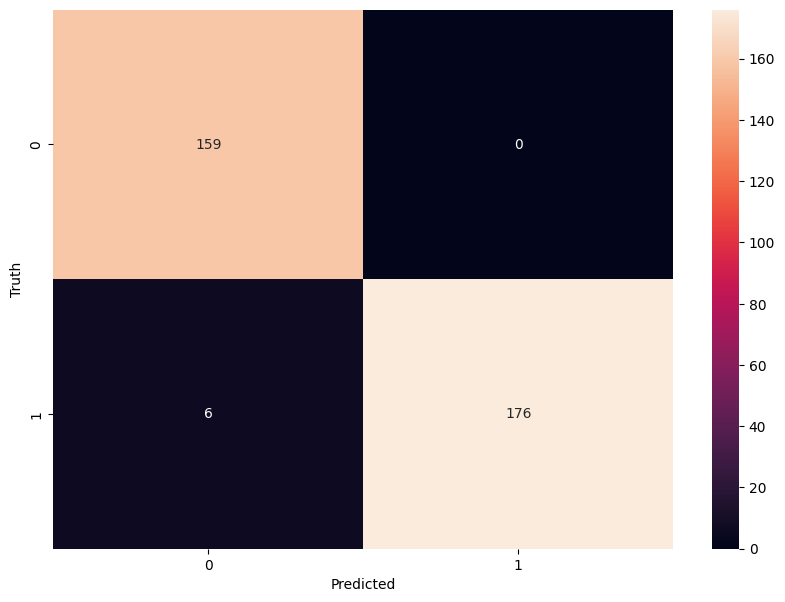

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suponha que você tenha um modelo treinado chamado 'model'
# E você usa o conjunto de validação para fazer previsões
y_pred = model.predict(val_ds)

# Converta as previsões em rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenha os rótulos verdadeiros do conjunto de validação
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calcule a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [31]:
import numpy as np

# Suponha que `model.predict(val_ds)` retorne um array bidimensional, onde cada linha representa uma amostra e cada coluna representa a probabilidade de uma classe
predictions = model.predict(val_ds)

# Encontre a classe com a maior probabilidade para cada amostra
predicted_classes = np.argmax(predictions, axis=1)

# Encontre a probabilidade da classe prevista para cada amostra
predicted_probabilities = np.max(predictions, axis=1)

import os
import tensorflow as tf

from pathlib import Path

data_dir = Path("data/cuted")

batch_size = 32
img_height = 180
img_width = 180

# Obtenha a lista de todos os arquivos de imagem
all_image_paths = list(data_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# Divida a lista de caminhos de imagem em conjuntos de treinamento e validação
train_image_paths = all_image_paths[:int(len(all_image_paths)*0.8)]
val_image_paths = all_image_paths[int(len(all_image_paths)*0.8):]

# Crie um tf.data.Dataset a partir dos caminhos de imagem
list_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)

# Função para carregar e pré-processar as imagens
def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  img /= 255.0
  return img

# Crie um tf.data.Dataset de imagens
val_ds = list_ds.map(process_path).batch(batch_size)

# Agora você tem uma lista `val_image_paths` contendo os caminhos de todas as imagens no conjunto de validação
# Você pode usar esta lista para obter o nome do arquivo de imagem durante a predição
for i in range(len(predicted_classes)):
  
    print(f"Sample {os.path.basename(val_image_paths[i])}: Class {class_names[predicted_classes[i]]}, Probability {predicted_probabilities[i]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Sample page_718_p3_cropped.png: Class non-header, Probability 16.794570922851562
Sample page_1527_p7.png: Class header, Probability 7.408111572265625
Sample page_108_p5_cropped.png: Class non-header, Probability 10.914782524108887
Sample page_38_p1_cropped.png: Class non-header, Probability 9.331588745117188
Sample page_853_p3_cropped.png: Class non-header, Probability 15.737671852111816
Sample page_593_p4_cropped.png: Class non-header, Probability 15.198081970214844
Sample page_92_p5_cropped.png: Class non-header, Probability 13.361239433288574
Sample page_906_p3_cropped.png: Class header, Probability 16.204708099365234
Sample page_778_p3_cropped.png: Class non-header, Probability 7.398183822631836
Sample page_420_p5_cropped.png: Class non-header, Probability 7.941562175750732
Sample page_737_p1_cropped.png: Class non-header, Probability 0.49924588203430176
Sample page_415_p3_cropped.png: Class header, Probability 4.014227390289307
Sample page_688